In [1]:
import requests
from bs4 import BeautifulSoup
import regex as re
from tqdm.notebook import tqdm
import pandas as pd
import time
from math import ceil

import wget
import os

ModuleNotFoundError: No module named 'regex'

Text(0, 0.5, 'Verschillende aanduidingen')

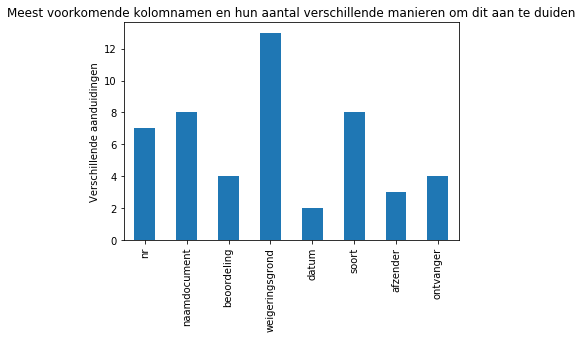

In [2]:
import pandas as pd

options = {
        "nr": ["nr", "nummer", "volgnummer", "docnr", "documentnr", "id", "documentnummer"],
        "naamdocument": ["document", "documentnaam", "titeldocument", "titeldoc", "onderwerp", "naamdocument", "titel", "naam"],
        "beoordeling": ["beoordeling", "beroordeling", "oordeel", "beoordelingwob"],
        "weigeringsgrond": ["weigeringsgrond", "artikelwob", "wob", "beslissingconform", "wobgrond", "uitzonderingsgrond", "artikel", "wobartikel", "weigeringsgrondwob", "weigeringsgronden",
                            "lakgrond", "relevantewobgronden", "grond"],
        "datum": ["datum", "datumdocument"],
        "soort": ["soort", "soortdocument", "type", "categorie", "documenttype", "typedocument", "soortstuk", "documentsoort"],
        "afzender": ["afzender", "afzenders", "van"],
        "ontvanger": ["ontvanger", "ontvangers", "naar", "aan"]
    }

options_count = pd.Series({option: len(options[option]) for option in options})
options_count.plot(kind='bar', title='Meest voorkomende kolomnamen en hun aantal verschillende manieren om dit aan te duiden').set_ylabel('Verschillende aanduidingen')

In [2]:
def get_doc_type(doclink):
    """
    Based on the link to a doc, try to identify the type of document.
    """
    doclink = doclink.lower()
    
    options = {'Inventaris': ['inventaris'], 'Vrijgegeven document': ['bijlage', 'document', 'agenda', 'verslag'], 'Besluit': ['besluit', 'beslissing']}
    
    for option in options:
        for keyword in options[option]:
            if keyword in doclink:
                return option

    return 'Vrijgegeven document'

In [4]:
def date_to_date(textdate):
    
    months = {'januari': '01', 'februari': '02', 'maart': '03', 'april': '04', 'mei': '05', 'juni': '06', 'juli': '07',
              'augustus': '08', 'september': '09', 'oktober': '10', 'november': '11', 'december': '12'}
    
    day = textdate.split()[0]
    month = months[textdate.split()[1]]
    year = textdate.split()[2]
    
    return f"{year}-{month}-{day}"
    
    

In [6]:
r = requests.get('https://www.noord-holland.nl/Loket/Pilot_actieve_openbaarmaking')
soup = BeautifulSoup(r.content,'html.parser')

wobs = soup.find_all(class_='row-link')

json_wobs = []

for number, wob in enumerate(wobs):
    
    json_wob = {}
    json_wob['identifier'] = f'NH-ZW-{number+1}'
    json_wob['title'] = wob.string.strip()
    json_wob['type'] = 'Actieve openbaarmaking'
    json_wob['topic'] = 'Zonneweide Jaagweg'
    json_wob['idTopic'] = '2093'
    json_wob['handledBy'] = 'Gedeputeerde Staten van Noord-Holland'
    
    r2 = requests.get('https://www.noord-holland.nl/' + wob['href'])
    soup2 = BeautifulSoup(r2.content, 'html.parser')
    
    
    json_wob['numberDocuments'] = len(soup2.find_all(class_='objectinfo'))
    
    try:
        json_wob['decisionDate'] = date_to_date(soup2.find(class_='objectinfo').contents[0].strip().strip('(,'))
    except:
        pass

    documents = []
    for number, doc in enumerate(soup2.find(class_='grid-6 push-3 content-area').find_all('li')):
        
        document = {}
        document['identifier'] = json_wob['identifier'] + '-' + str(number+1)
        document['fileName'] = doc.find('a')['href'].split('/')[-1]
        document['fileExtension'] = document['fileName'].split('.')[-1]
        document['mimeType'] = 'application/pdf'
        document['documentType'] = get_doc_type(document['fileName'])
        document['url'] = 'https://www.noord-holland.nl' + doc.find('a')['href']
        document['downloadDate'] = '2022-04-01'
        document['language'] = 'nld'
        document['title'] = doc.find('a').string.strip()
        document['fileSize'] = doc.find(class_='objectinfo').contents[-1].strip(',').strip().strip(')')
        document['crawler'] = 'UvA-IK-TestCrawler'
        
        documents.append(document)
        
    json_wob['documents'] = documents
        
        
    json_wobs.append(json_wob)
    
print(json_wobs)

[{'identifier': 'NH-ZW-1', 'title': 'Zonneweide Jaagweg (sept, okt, nov, dec 2021)', 'type': 'Actieve openbaarmaking', 'topic': 'Zonneweide Jaagweg', 'idTopic': '2093', 'handledBy': 'Gedeputeerde Staten van Noord-Holland', 'numberDocuments': 9, 'decisionDate': '2021-12-23', 'documents': [{'identifier': 'NH-ZW-1-1', 'fileName': 'Besluit_actieve_openbaarmaking_Zonneweide_Jaagweg_sept_okt_nov_dec_2021.pdf', 'fileExtension': 'pdf', 'mimeType': 'application/pdf', 'documentType': 'Besluit', 'url': 'https://www.noord-holland.nl/Loket/Pilot_actieve_openbaarmaking/Documenten/Zonneweide_Jaagweg_sept_okt_nov_dec_2021/Besluit_actieve_openbaarmaking_Zonneweide_Jaagweg_sept_okt_nov_dec_2021.pdf', 'downloadDate': '2022-04-01', 'language': 'nld', 'title': 'Besluit actieve openbaarmaking Zonneweide Jaagweg sept okt nov dec 2021', 'fileSize': '159kB', 'crawler': 'UvA-IK-TestCrawler'}, {'identifier': 'NH-ZW-1-2', 'fileName': 'Inventarisatielijst_sept_okt_nov_dec_2021_dossier_zonneweide_Jaagweg.pdf', 'fil

In [7]:
import json

with open('zonneweide2.json', 'w') as f:
    json.dump(json_wobs, f)